In [68]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [69]:
import geopandas as gpd
import osmnx as ox
from shapely import geometry
from quetzal.model import stepmodel
from syspy.spatial.graph.graphbuilder import OsmnxCleaner

# Preparation of the transport network.
## Saves road infrastructure built with OSMNX
Needs StepModel with zones

In [70]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [76]:
# Loading StepModel with zones
sm = stepmodel.read_json(model_path + 'ber_zones')

In [77]:
sm.zones = gpd.GeoDataFrame(sm.zones)
sm.zones.head(3)

,uuid,sch,nam,gdf,bezeich,zoneIndex,geometry
index,,,,,,,
0,DEBE04YY5000000B,110000040403,Schmargendorf,3588120.0,AX_KommunalesGebiet,0,"POLYGON ((13.29467 52.49183, 13.29468 52.49182..."
1,DEBE04YY50000001,110000040405,Westend,13527378.0,AX_KommunalesGebiet,1,"POLYGON ((13.28117 52.53048, 13.28179 52.53028..."
2,DEBE01YYK0000001,110000010103,Hansaviertel,528303.0,AX_KommunalesGebiet,2,"POLYGON ((13.34537 52.52250, 13.34547 52.52248..."


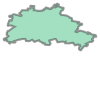

In [78]:
# Get the reference geometric hull
sm.hull = sm.zones["geometry"].buffer(1e-3).unary_union
sm.hull

## Create a road network

### discuss whether custom filter also applies for this project or whether more detailed road network should be included 

In [79]:
# Download filtered network from OpenStreetMap
#custom_filter = '["area"!~"yes"]["highway"!~"tertiary|living_street|residential|cycleway|footway|path|pedestrian|steps|track|corridor|elevator|escalator|proposed|construction|bridleway|abandoned|platform|raceway|service|bus_stop|no|razed|emergency_bay|rest_area|planned|escape|turning_circle|access_ramp|disused"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["access"!~"private"]["service"!~"parking|parking_aisle|driveway|private|emergency_access"]'
custom_filter = '["area"!~"yes"]["highway"~"motorway|primary|secondary|trunk|motorway_link|primary_link|secondary_link|trunk_link"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["access"!~"private"]["service"!~"parking|parking_aisle|driveway|private|emergency_access"]'
G = ox.graph_from_polygon(sm.hull, simplify=True, custom_filter=custom_filter)

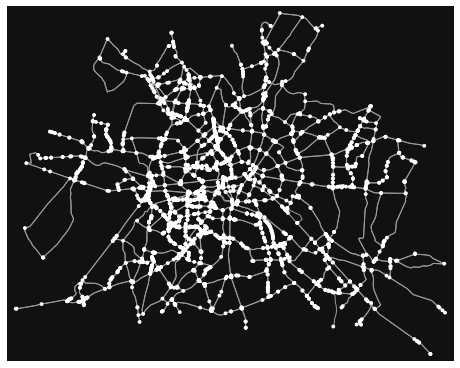

In [20]:
# Show the network graph
if manual: ox.plot_graph(G)

In [350]:
# Get Geodataframes
road_nodes, road_links = ox.graph_to_gdfs(G)

## Clean the network graph

In [298]:
# road_links.index

In [299]:
# road_nodes['osmid'] = road_nodes['osmid'].astype(str)

In [332]:
road_nodes.head(1)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)


In [333]:
road_nodes.index = road_nodes.index.astype(str)

In [334]:
road_nodes.head(1)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)


In [335]:

road_nodes = road_nodes.set_index(['osmid'])
# road_nodes = road_nodes.set_index('osmid')[['geometry']]

KeyError: "None of ['osmid'] are in the columns"

In [304]:
road_links.head(2)

osmid  oneway  \
u      v        key                                             
172546 28345850 0                             4638312    True   
       172594   0    [24295532, 969524322, 969524324]   False   

                                  name    highway  maxspeed   length  \
u      v        key                                                    
172546 28345850 0    Emmentaler Straße  secondary        50   64.155   
       172594   0    Emmentaler Straße  secondary  [30, 50]  646.628   

                                                              geometry lanes  \
u      v        key                                                            
172546 28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   NaN   
       172594   0    LINESTRING (13.35225 52.56774, 13.35266 52.567...     2   

                     ref bridge tunnel junction service width access  
u      v        key                                                   
172546 28345850 0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  
       172594   0    NaN    NaN    NaN      NaN     NaN   NaN    NaN

In [338]:
# added to avoid error öater on where columns 'osmid' and ['u', 'v'] dont exist
# road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()  


In [339]:
road_links.head(2)

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,ref,bridge,tunnel,junction,service,width,access
0,172546,28345850,0,4638312,True,Emmentaler Straße,secondary,50,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172546,172594,0,"[24295532, 969524322, 969524324]",False,Emmentaler Straße,secondary,"[30, 50]",646.628,"LINESTRING (13.35225 52.56774, 13.35266 52.567...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
# road_links[['u', 'v']] = road_links[['u', 'v']].astype(str)
road_links_not_astype_str = road_links
road_links[['u', 'v', "key"]] = road_links[['u', 'v', "key"]].astype(str)
road_links['highway'] = road_links['highway'].astype(str)

In [341]:
road_links.head(2)

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,ref,bridge,tunnel,junction,service,width,access
0,172546,28345850,0,4638312,True,Emmentaler Straße,secondary,50,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172546,172594,0,"[24295532, 969524322, 969524324]",False,Emmentaler Straße,secondary,"[30, 50]",646.628,"LINESTRING (13.35225 52.56774, 13.35266 52.567...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [351]:
road_links = road_links.set_index(["u","v","key"], drop = True)

KeyError: "None of ['u', 'v', 'key'] are in the columns"

In [343]:
road_links['u'] = road_links_not_astype_str['u']
road_links['v'] = road_links_not_astype_str['v']
road_links['key'] = road_links_not_astype_str['key']

In [344]:
road_links['u']

u           v           key
172546      28345850    0      NaN
            172594      0      NaN
172562      530351      0      NaN
            34694336    0      NaN
            21509248    0      NaN
                              ... 
9278832057  29787097    0      NaN
9383965239  1679931219  0      NaN
            9238368751  0      NaN
9428753897  287932784   0      NaN
                        1      NaN
Name: u, Length: 5633, dtype: object

In [317]:
road_links_not_astype_str['u']

0           172546
1           172546
2           172562
3           172562
4           172562
           ...    
5628    9278832057
5629    9383965239
5630    9383965239
5631    9428753897
5632    9428753897
Name: u, Length: 5633, dtype: object

In [316]:
road_links.head(2)

osmid  oneway  \
u      v        key                                             
172546 28345850 0                             4638312    True   
       172594   0    [24295532, 969524322, 969524324]   False   

                                  name    highway  maxspeed   length  \
u      v        key                                                    
172546 28345850 0    Emmentaler Straße  secondary        50   64.155   
       172594   0    Emmentaler Straße  secondary  [30, 50]  646.628   

                                                              geometry lanes  \
u      v        key                                                            
172546 28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   NaN   
       172594   0    LINESTRING (13.35225 52.56774, 13.35266 52.567...     2   

                     ref bridge tunnel junction service width access    u  \
u      v        key                                                         
172546 28345850 0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   
       172594   0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   

                       v  key  
u      v        key            
172546 28345850 0    NaN  NaN  
       172594   0    NaN  NaN

In [296]:
road_links["u"]

u           v           key
172546      28345850    0      NaN
            172594      0      NaN
172562      530351      0      NaN
            34694336    0      NaN
            21509248    0      NaN
                              ... 
9278832057  29787097    0      NaN
9383965239  1679931219  0      NaN
            9238368751  0      NaN
9428753897  287932784   0      NaN
                        1      NaN
Name: u, Length: 5633, dtype: object

In [253]:
road_links.head(2)

osmid  oneway  \
u      v        key                                             
172546 28345850 0                             4638312    True   
       172594   0    [24295532, 969524322, 969524324]   False   

                                  name    highway  maxspeed   length  \
u      v        key                                                    
172546 28345850 0    Emmentaler Straße  secondary        50   64.155   
       172594   0    Emmentaler Straße  secondary  [30, 50]  646.628   

                                                              geometry lanes  \
u      v        key                                                            
172546 28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   NaN   
       172594   0    LINESTRING (13.35225 52.56774, 13.35266 52.567...     2   

                     ref bridge tunnel junction service width access    u  \
u      v        key                                                         
172546 28345850 0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   
       172594   0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   

                       v  key  
u      v        key            
172546 28345850 0    NaN  NaN  
       172594   0    NaN  NaN

In [254]:
road_links.index

MultiIndex([(    '172546',   '28345850', '0'),
            (    '172546',     '172594', '0'),
            (    '172562',     '530351', '0'),
            (    '172562',   '34694336', '0'),
            (    '172562',   '21509248', '0'),
            (    '172564',   '21509247', '0'),
            (    '172564',  '186969527', '0'),
            (    '172566',     '530318', '0'),
            (    '172566',   '29690840', '0'),
            (    '172587',     '530205', '0'),
            ...
            ('9276032162', '9276032172', '0'),
            ('9276032172',   '28382470', '0'),
            ('9276032191', '9276032162', '0'),
            ('9276032191', '4453131211', '0'),
            ('9276290131',  '261022482', '0'),
            ('9278832057',   '29787097', '0'),
            ('9383965239', '1679931219', '0'),
            ('9383965239', '9238368751', '0'),
            ('9428753897',  '287932784', '0'),
            ('9428753897',  '287932784', '1')],
           names=['u', 'v', 'key'], length=

In [128]:
road_links.head(2)

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,ref,bridge,tunnel,junction,service,width,access
0,172546,28345850,0,4638312,True,Emmentaler Straße,secondary,50,64.155,"LINESTRING (13.35225 52.56774, 13.35132 52.56762)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172546,172594,0,"[24295532, 969524322, 969524324]",False,Emmentaler Straße,secondary,"[30, 50]",646.628,"LINESTRING (13.35225 52.56774, 13.36081 52.57033)",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
road_links.head(2)

,u,v,key,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,ref,bridge,tunnel,junction,service,width,access
0,172546,28345850,0,4638312,True,Emmentaler Straße,secondary,50,64.155,"LINESTRING (13.35225 52.56774, 13.35132 52.56762)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172546,172594,0,"[24295532, 969524322, 969524324]",False,Emmentaler Straße,secondary,"[30, 50]",646.628,"LINESTRING (13.35225 52.56774, 13.36081 52.57033)",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
road_links.head(2)

osmid  oneway  \
u      v        key                                             
172546 28345850 0                             4638312    True   
       172594   0    [24295532, 969524322, 969524324]   False   

                                  name    highway  maxspeed   length  \
u      v        key                                                    
172546 28345850 0    Emmentaler Straße  secondary        50   64.155   
       172594   0    Emmentaler Straße  secondary  [30, 50]  646.628   

                                                              geometry lanes  \
u      v        key                                                            
172546 28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   NaN   
       172594   0    LINESTRING (13.35225 52.56774, 13.35266 52.567...     2   

                     ref bridge tunnel junction service width access    u  \
u      v        key                                                         
172546 28345850 0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   
       172594   0    NaN    NaN    NaN      NaN     NaN   NaN    NaN  NaN   

                       v  key  
u      v        key            
172546 28345850 0    NaN  NaN  
       172594   0    NaN  NaN

In [352]:
# reduces links to their start and end point
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [353]:
cleaner = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='u', 
    b='v')

cleaner.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False)

KeyError: 'b'

In [347]:
road_links.head(1)

,,,osmid,oneway,name,highway,maxspeed,length,geometry,lanes,ref,bridge,tunnel,junction,service,width,access,u,v,key
u,v,key,,,,,,,,,,,,,,,,,,
172546,28345850,0,4638312,True,Emmentaler Straße,secondary,50,64.155,"LINESTRING (13.35225 52.56774, 13.35132 52.56762)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
# up = (list(map(lambda x: list(x.coords), list(road_links.geometry))))
up = (list(map(lambda x: list(x.coords), list(road_nodes.geometry))))

In [236]:
sum(up[0][0])+sum(up[0][0]) != sum(up[0][0])+sum(up[0][0])

False

In [238]:
list(filter(lambda x: sum(x[0])+sum(x[-1]) != sum(x[0])+sum(x[-1]), up))

[]

In [327]:
import numpy as np
x = float("nan")
y = numpy.nan
float("nan") is float("nan"), float("nan") is np.nan, np.nan is float("nan"), np.nan is np.nan

(False, False, False, True)

In [349]:
cleaner.clean_geometries()

KeyError: nan

In [60]:
# Apply the quetzal road network cleaner
cleaner = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='u', 
    b='v')
cleaner.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False)
cleaner.clean_geometries()
cleaner.fix_nodeset_consistency()

KeyError: False

In [61]:
# Add road links to the stepmodel
sm.road_links = cleaner.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed', 'lanes']]
sm.road_links['id'] = ['rl_' + str(ind) for ind in sm.road_links.index]
sm.road_links.set_index('id', drop=True, inplace=True)
sm.road_links.head()

,a,b,length,geometry,highway,maxspeed,lanes
id,,,,,,,
rl_1,172546,28345850,64.155,"LINESTRING (13.35225 52.56774, 13.35132 52.56762)",secondary,50,NaN
rl_2,172546,172594,646.628,"LINESTRING (13.35225 52.56774, 13.36081 52.57033)",secondary,"[30, 50]",2
rl_3,172562,530351,13.660,"LINESTRING (13.33064 52.56262, 13.33047 52.56255)",primary_link,50,2
rl_4,172562,34694336,1124.293,"LINESTRING (13.33064 52.56262, 13.34515 52.56680)",secondary,50,2
rl_5,172562,21509248,239.484,"LINESTRING (13.33064 52.56262, 13.32803 52.56407)",secondary,50,"[4, 2]"


In [13]:
# Add road nodes to the stepmodel
sm.road_nodes = cleaner.nodes[['geometry']]
sm.road_nodes.head()

,geometry
osmid,
5125955591,POINT (12.50832 51.13886)
27000880,POINT (7.02550 50.58543)
205403679,POINT (8.14727 51.25863)
273142630,POINT (9.71858 48.45182)
2749374176,POINT (12.63433 54.05378)


In [14]:
len(sm.road_links.index)

489649

In [15]:
len(sm.road_nodes.index)

172538

In [33]:
# Fix the network integrity
sm.integrity_fix_collision()
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)
sm.integrity_fix_road_nodeset_consistency()

direct: 172538it [01:39, 1726.13it/s]
reversed: 172538it [01:39, 1739.11it/s]
162487it [01:39, 1627.28it/s]


In [34]:
# Check the road network integrity
sm.integrity_test_road_network(cutoff=10)
sm.missing_road_nodes

162487it [01:31, 1768.37it/s]


set()


### Length and speed

In [ ]:
# Set length of links
sm.road_links["length"] = pd.to_numeric(sm.road_links["length"])

In [ ]:
# Set speed in km/h
default_speed = 0
def get_vmax(s):
    v_max = default_speed
    if isinstance(s, str):
        if s.startswith("["):
            v_list_str = s[1:-1].split(", ")
            v_list_str = [v[1:-1] for v in v_list_str]
            v_list = []
            for v in v_list_str:
                try:
                    v_list.append(int(v))
                except ValueError:
                    pass
            try:
                v_max = max(v_list)
            except ValueError:
                pass
        else:
            try:
                v_max = int(s)
            except ValueError:
                pass
    elif isinstance(s, int) or isinstance(s, float):
        v_max = s
    return v_max
sm.road_links["maxspeed"] = sm.road_links["maxspeed"].apply(get_vmax)
sm.road_links["maxspeed"].fillna(default_speed, inplace=True, downcast='infer')

In [ ]:
# Length of road network
sm.road_links['length'].sum()/1000

In [ ]:
# Length of road network without any speed assigned
sm.road_links.loc[sm.road_links['maxspeed']==default_speed]['length'].sum()/1000

In [ ]:
# Number of links (not length) with specified speeds
if manual: sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [ ]:
# Length of road network with multiple highway classifications
sm.road_links.loc[sm.road_links['highway'].str.startswith('[')]['length'].sum()/1000

In [ ]:
sm.road_links['highway'].unique()

In [ ]:
# Retreive main road types
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
temp = sm.road_links.loc[(sm.road_links['maxspeed']!=default_speed) &
                         (sm.road_links['highway'].isin(main_types))
                        ].set_index('highway', drop=True)
weighted_speeds = temp.groupby(temp.index).apply(
    lambda x: int(np.average(x.maxspeed, weights=x.length)))
weighted_speeds

In [ ]:
weighted_speeds.mean()

In [ ]:
# On German motorways without speed limit MIV average speed is 125 km/h
# https://www.zukunft-mobilitaet.net/171117/analyse/gefahrene-geschwindigkeiten-auf-autobahnen-ohne-tempolimit-verteilung-deutschland/
sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                  (sm.road_links['highway']=='motorway'), 'maxspeed'] = 125
# All other road types are attributed according to the mean speed limit for their type
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
for t in main_types:
    try:
        sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                          (sm.road_links['highway']==t), 'maxspeed'] = weighted_speeds[t]
    except KeyError:
        print('No benchmark speed for highway type ' + t)
# The rest is a mix of all road types
sm.road_links['maxspeed'] = sm.road_links['maxspeed'].replace(
    default_speed, int(weighted_speeds.mean()))

In [ ]:
# Number of links (not length) with specified speeds
if manual: sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

## Save road network

In [35]:
# Make links table smaller
sm.road_links['length'] = sm.road_links['length'].astype(int)

In [18]:
# Split road links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['highway', 'length', 'maxspeed', 'lanes']
auxiliary = sm.road_links[cols]
sm.road_links.drop(cols, axis=1, inplace=True)

In [40]:
sm.to_json(input_path + 'de_road_network', only_attributes=[
    'road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [03:01<00:00,  5.03s/it]


In [23]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(input_path + 'de_road_network/road_links_quetzaldata.json')